#**Lab Distributed Data Analytics**

##Tutorial 3

In [ ]:
#Displaying information about the CPU architecture
import subprocess
result = subprocess.run(['lscpu'], stdout=subprocess.PIPE, shell=True, text=True)
print(result.stdout[:800])

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Byte Order:                      Little Endian
Address sizes:                   46 bits physical, 48 bits virtual
CPU(s):                          2
On-line CPU(s) list:             0,1
Thread(s) per core:              2
Core(s) per socket:              1
Socket(s):                       1
NUMA node(s):                    1
Vendor ID:                       GenuineIntel
CPU family:                      6
Model:                           79
Model name:                      Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:                        0
CPU MHz:                         2200.160
BogoMIPS:                        4400.32
Hypervisor vendor:               KVM
Virtualization type:             full
L1d cache:  


In [ ]:
import os
os.cpu_count() #number of logical CPU cores

2

In [ ]:
#Verifying open mpi installation
!ompi_info --version

Open MPI v4.0.3

http://www.open-mpi.org/community/help/


In [ ]:
#Installing python library mpi4py
!pip install --quiet mpi4py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### 1 Load the Data

In [ ]:
#Uploading the file from Google drive
id = '1ThvAlpdgL2njClDDsCInADaMS9UTHjcw'

!wget --no-check-certificate --quiet 'https://docs.google.com/uc?export=download&id={id}' -O cluster_data.csv

In [ ]:
import pandas as pd

df = pd.read_csv("cluster_data.csv", header=0, index_col=0)
df

,x,y
0,-1.066267,-1.073793
1,-0.534204,-0.886694
2,-1.091807,-0.981547
3,-1.353266,-0.762833
4,-1.117779,-0.763639
...,...,...
395,1.155243,0.558194
396,1.159506,0.377489
397,0.571360,0.942956
398,1.031360,0.966871


<Axes: title={'center': 'Data points'}, xlabel='x', ylabel='y'>

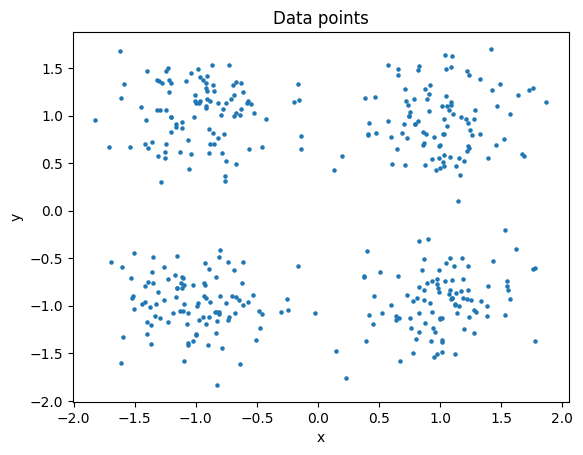

In [ ]:
df.plot(x='x', y='y', kind='scatter', title='Data points', marker='.')

### 2 Ramp Up y 3 K-Means

In [ ]:
# %%writefile ex2.py

from mpi4py import MPI
import numpy as np
import pandas as pd
import sys

comm = MPI.COMM_WORLD                   #communicator
rank = comm.Get_rank()                  #number of the process running the code
size = comm.Get_size()                  #total number of processes running
myHostName = MPI.Get_processor_name()   #machine name running the code

np.random.seed(seed=3116)

#Clustering with K-mean
def centroid(vector,centroids):

  cluster = np.zeros(len(vector))

  for idx, row in enumerate(vector):
    distances = list()
    for centroid in centroids:
      d = ((row-centroid)**2).sum()**(1/2) #euclidean distance
      distances.append(d)
    cluster[idx] = np.argmin(distances) #assign the closest cluster

  new_centroids = pd.DataFrame(vector).groupby(by=cluster).mean().values

  if len(new_centroids) != len(centroids): #safe when there is a cluster with no samples
    new_centroids = centroids

  return new_centroids, cluster

def K_mean(K):

  t_0 = MPI.Wtime() #start time

  if size == 1: #code execute if the number of process is 1 (no parallelization)

    df_data = pd.read_csv("cluster_data.csv", header=0, index_col=0).values

    t_1 = MPI.Wtime() #time to load the data

    print('Time to load the data:',t_1-t_0)

    idx = np.random.choice(len(df_data), K, replace=False) #random indices among the elements of vector
    centroids = np.array(df_data)[idx] #centroid matrix

    i = 0
    converge = True
    while converge: #iterative process

      new_centroids, cluster = centroid(df_data,centroids)
      if abs((new_centroids - centroids).sum()) < 0.01: #difference between two consecutive set of centroids
        converge = False
      else:
        centroids = new_centroids
        i += 1

    t_2 = MPI.Wtime() #timing the clusterization

    print('Time to clusterize the data:',t_2-t_1)

    #Exporting dataframes as csv files
    pd.DataFrame(cluster).to_csv(f'ex2_cluster.csv',index=False,header=False)
    pd.DataFrame(new_centroids).to_csv(f'ex2_centroids.csv',index=False,header=False)

  else: #code execute if the number of process is greater than 1 (parallelization)

    splits = None
    centroids = None
    converge = True

    if rank == 0: #master node

      df_data = pd.read_csv("cluster_data.csv", header=0, index_col=0).values

      t_1 = MPI.Wtime() #time to load the data

      print('Time to load the data:',t_1-t_0)

      splits = np.array_split(np.random.permutation(df_data), size, axis=0) #spliting the dataset

      idx = np.random.choice(len(df_data), K, replace=False) #random indices among the elements of vector
      centroids = np.array(df_data)[idx] #centroid matrix

      i = 0

    portion = comm.scatter(splits, root=0) #chunks are distributed across the workers

    while converge: #iterative process

      centroids = comm.bcast(centroids, root=0) #centroids are distributed across the workers

      new_centroids, cluster = centroid(portion,centroids) #each worker computes a new set of centroids
      data = comm.gather(new_centroids, root=0)

      if rank == 0:
        new_centroids = np.array(data).mean(axis=0)

        if abs((new_centroids - centroids).sum()) < 0.01: #master computes the difference between consecutive centroids
          converge = False
        else:
          centroids = new_centroids
          i += 1

      converge = comm.bcast(converge, root=0) #master signal when the algorithm has converged

    if rank == 0: #master node

      new_centroids, cluster = centroid(df_data,centroids)

      t_2 = MPI.Wtime() #timing the clusterization
      print('Time to clusterize the data:',t_2-t_1)

      #Exporting dataframes as csv files
      pd.DataFrame(cluster).to_csv(f'ex2_cluster.csv',index=False,header=False)
      pd.DataFrame(new_centroids).to_csv(f'ex2_centroids.csv',index=False,header=False)


K = int(sys.argv[1])

if rank == 0:
  print(f'Cores: {size}')
  print(f'K={K}')

K_mean(K)


MPI.Finalize()

Overwriting ex2.py


In [ ]:
#Pass number of clusters as argument
! mpirun --allow-run-as-root --use-hwthread-cpus -n 1 python ex2.py 4
! mpirun --allow-run-as-root --use-hwthread-cpus -n 2 python ex2.py 4

Cores: 1
K=4
Time to load the data: 0.004915908
Time to clusterize the data: 0.152037469
Cores: 2
K=4
Time to load the data: 0.004623903
Time to clusterize the data: 0.06454839


We can notice a reduction of 57% in the clusterization time when using with 2 cores

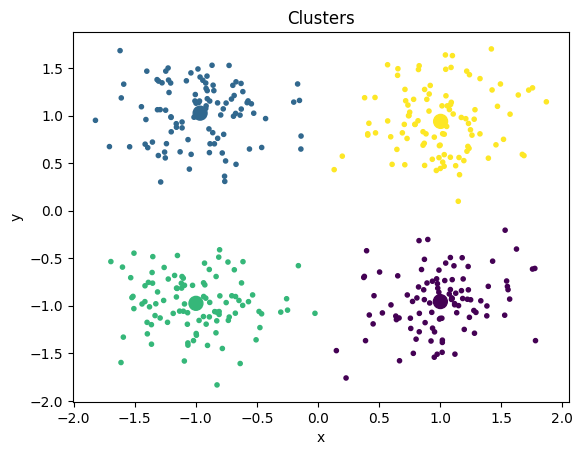

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

cluster = pd.read_csv("ex2_cluster.csv", header=None).values
centroids = pd.read_csv("ex2_centroids.csv", names=['x','y'])

fig, ax = plt.subplots()

ax.scatter(df['x'], df['y'], c=cluster, marker='.')
ax.scatter(centroids['x'], centroids['y'], s=100, c=np.arange(len(centroids)), marker='o')

ax.set_title('Clusters')
ax.set_xlabel('x')
ax.set_ylabel('y')

plt.show()